# The workflow using the Q-spec-reprocessed dataset

The spectra have been shuffled and randomly clustered into 7 clusters (prepare_for_reprocess.py). They are all reprocessed by Q-Spec. Part of spectra still need to be reprocessed later. 

Therefore, I'm going to collect those new Results.txt to determine what to do next.

In [ ]:
################## Import Packages #################### 
import time
import os
import numpy as np
import pandas as pd
import shutil

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hdbscan
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
%matplotlib inline

path = '\\\\10.110.16.10\\GeopolarLabor\\#Projekte\\WASA'
os.chdir(path)

date = time.strftime('%Y%m%d', time.localtime())

## Input Resuts

In [ ]:
results_df = pd.DataFrame()
for cluster in range(7):
  X = pd.read_table('XRF//data_shuffled//Results_shuffled_i5_c{}.txt'.format(cluster), skiprows = 2).drop('Unnamed: 59', axis = 1)
  results_df = results_df.append(X).reset_index(drop = True)

del X
results_df.shape

(170557, 59)

In [ ]:
results_df['MSE'].describe()

count    170557.000000
mean          1.197998
std           0.182122
min           0.880000
25%           1.100000
50%           1.160000
75%           1.250000
max          12.620000
Name: MSE, dtype: float64

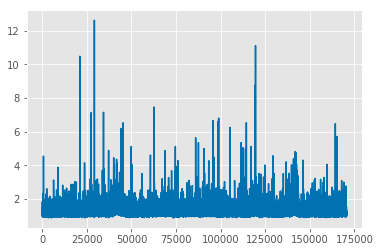

In [ ]:
results_df['MSE'].plot()

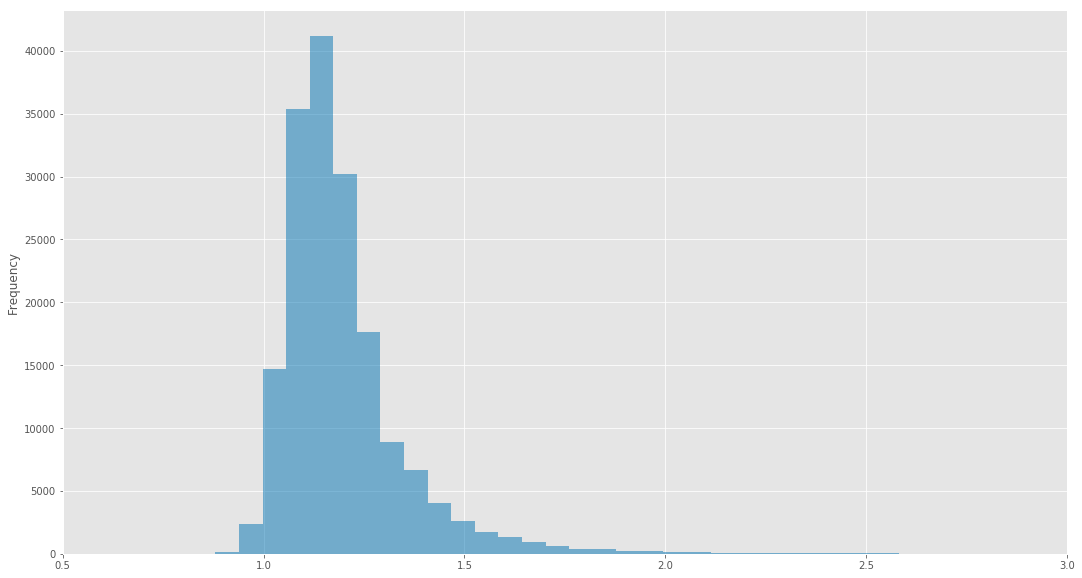

In [ ]:
results_df['MSE'].plot(kind = 'hist', alpha = 0.5, figsize = (18, 10), bins = 200, xlim = (0.5, 3), xticks = [0.5, 1, 1.5, 2, 2.5, 3])

In [ ]:
results_df[['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']].describe()

cps            MSE             Si              K  \
count  170557.000000  170557.000000  170557.000000  170557.000000   
mean    32046.681280       1.197998    3130.234332    3936.706843   
std      7850.662167       0.182122    1559.485038    1706.185130   
min      8301.000000       0.880000       0.000000      61.000000   
25%     27365.000000       1.100000    1982.000000    2854.000000   
50%     29832.000000       1.160000    2869.000000    3607.000000   
75%     35130.000000       1.250000    4183.000000    4821.000000   
max    220091.000000      12.620000    9799.000000   12271.000000   

                  Ca             Ti             Mn             Fe  
count  170557.000000  170557.000000  170557.000000  170557.000000  
mean    12212.996500    1986.561490     457.070176    4932.375974  
std     15603.284821    2219.871992     220.457948    5092.108161  
min        97.000000       0.000000       0.000000      53.000000  
25%      2506.000000     843.000000     311.000000    1700.000000  
50%      7585.000000    1536.000000     413.000000    2524.000000  
75%     15867.000000    2849.000000     541.000000    6699.000000  
max    303970.000000  332136.000000    3435.000000   54852.000000

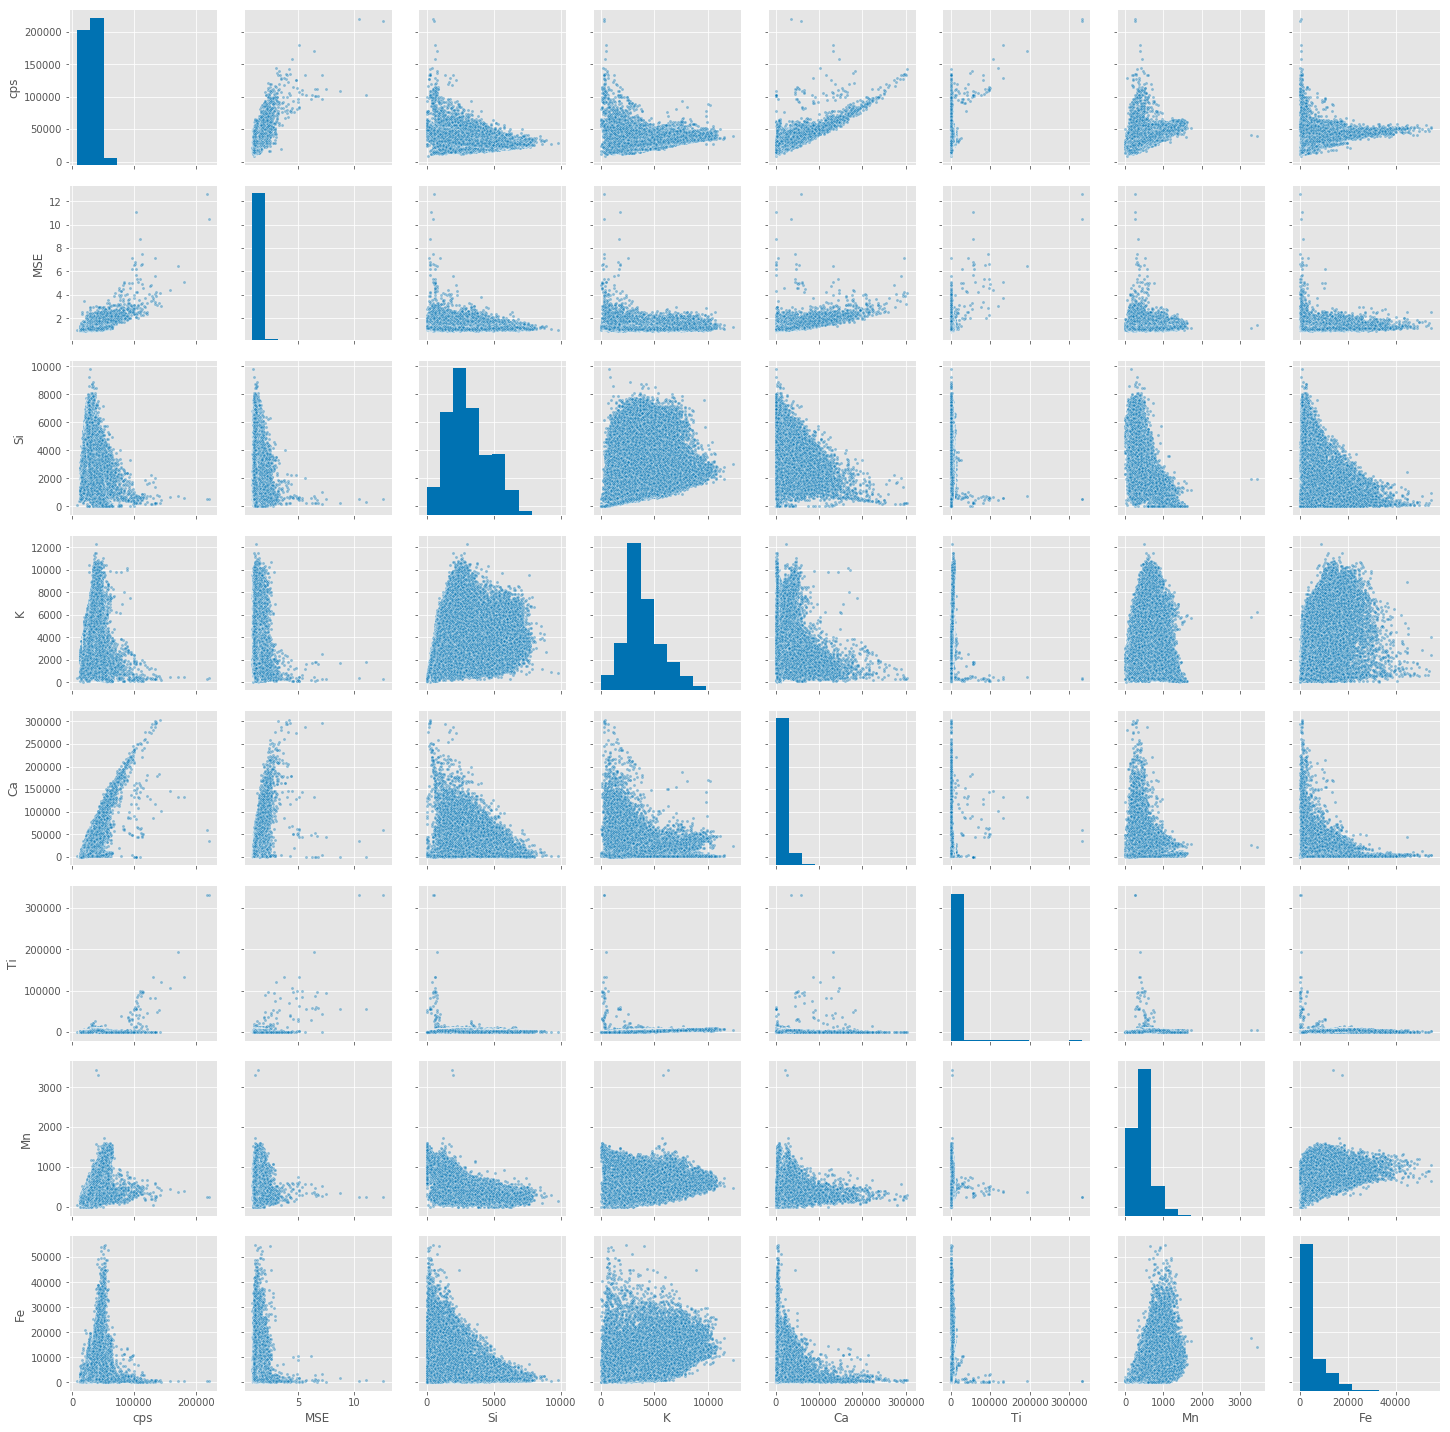

In [ ]:
g = sns.pairplot(results_df[['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']],
                plot_kws=dict(s=10, linewidth=0.5, alpha = 0.4),
                )

The direct way to separate data is using MSE. The high MSE value indicates the bad fitting and probably refer to those distinct sediments need different setting for reprocess. However, what is the value considered high?

(1) my experience suggest the reasonable value shouldn't higher than 2

(2) mean + 3 standard deviation to select the rest 0.14% of data (assuming normal distribution)

Other ways are using clustering analysis to select those data with too high value. I prefer to take (2) and see if those data points (high MSE) have different cluster characterisitcs.  If they do, I will reprocess them respectively.

## Select the data points with high MSE


In [ ]:
mse = results_df.MSE.mean() + 3 * results_df.MSE.std()
sel_results_df = results_df[results_df['MSE'] > mse]
X_df = sel_results_df[['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']].copy()
X_df.shape

(2270, 8)

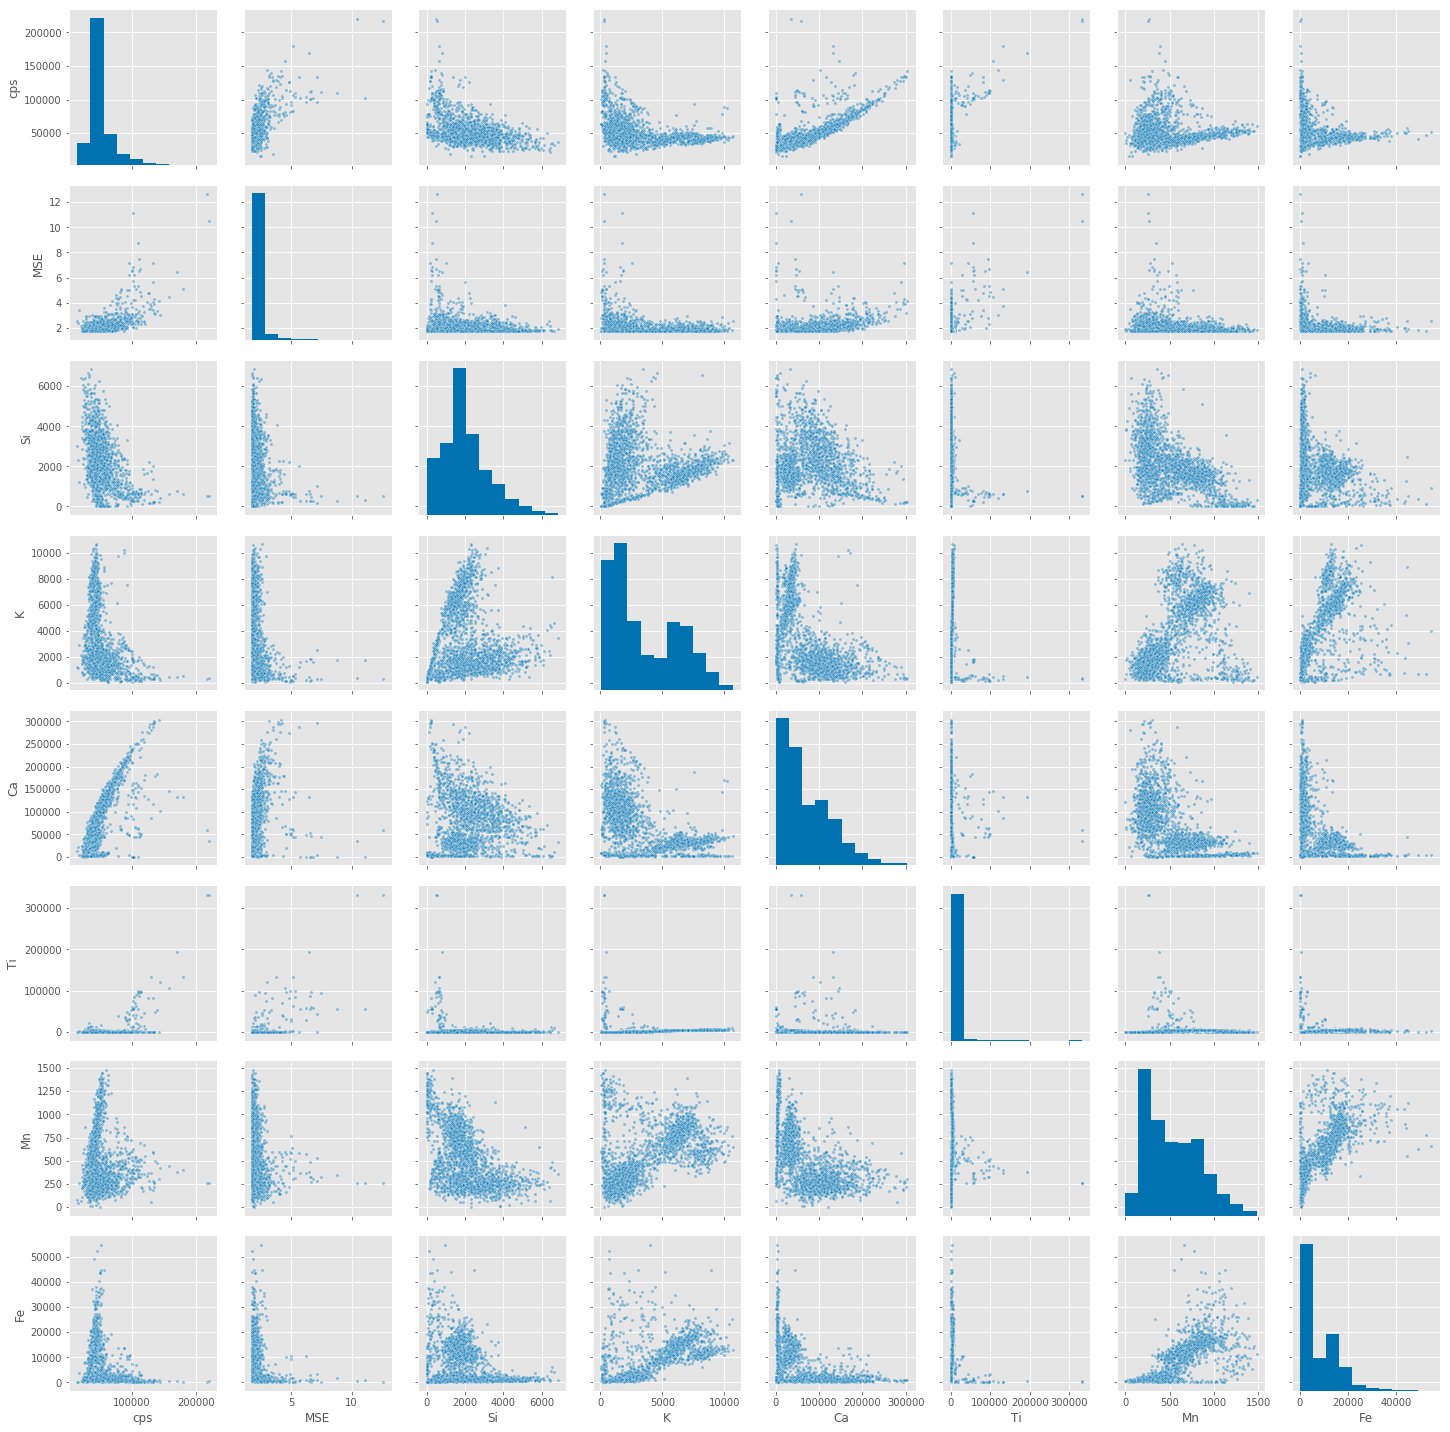

In [ ]:
g = sns.pairplot(X_df,
                plot_kws=dict(s=10, linewidth=0.5, alpha = 0.4),
                )

The elements (Si, K, Ca, Ti, Mn and Fe) seem to indicate some clusters in the data points, so I will use them for several clustering analyses.

## Clustering analysis

In [ ]:
X_std = StandardScaler().fit_transform(                  # need to standardized first
        X_df.iloc[:, 2:]                                 # select the columes that contain elemental data
        )

C:\Users\An-Sheng\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\An-Sheng\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### hdbscan

In [ ]:
labels_hdbscan = pd.Series(
    hdbscan.HDBSCAN(min_cluster_size = 15).fit(X_std).labels_)

In [ ]:
for cluster in np.sort(labels_hdbscan.unique()):
  print('C{}: {}'.format(cluster, labels_hdbscan[labels_hdbscan == cluster].count()))

C-1: 604
C0: 90
C1: 792
C2: 16
C3: 768


C:\Users\An-Sheng\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


C-1: 604 data points
C0: 90 data points
C1: 792 data points
C2: 16 data points
C3: 768 data points


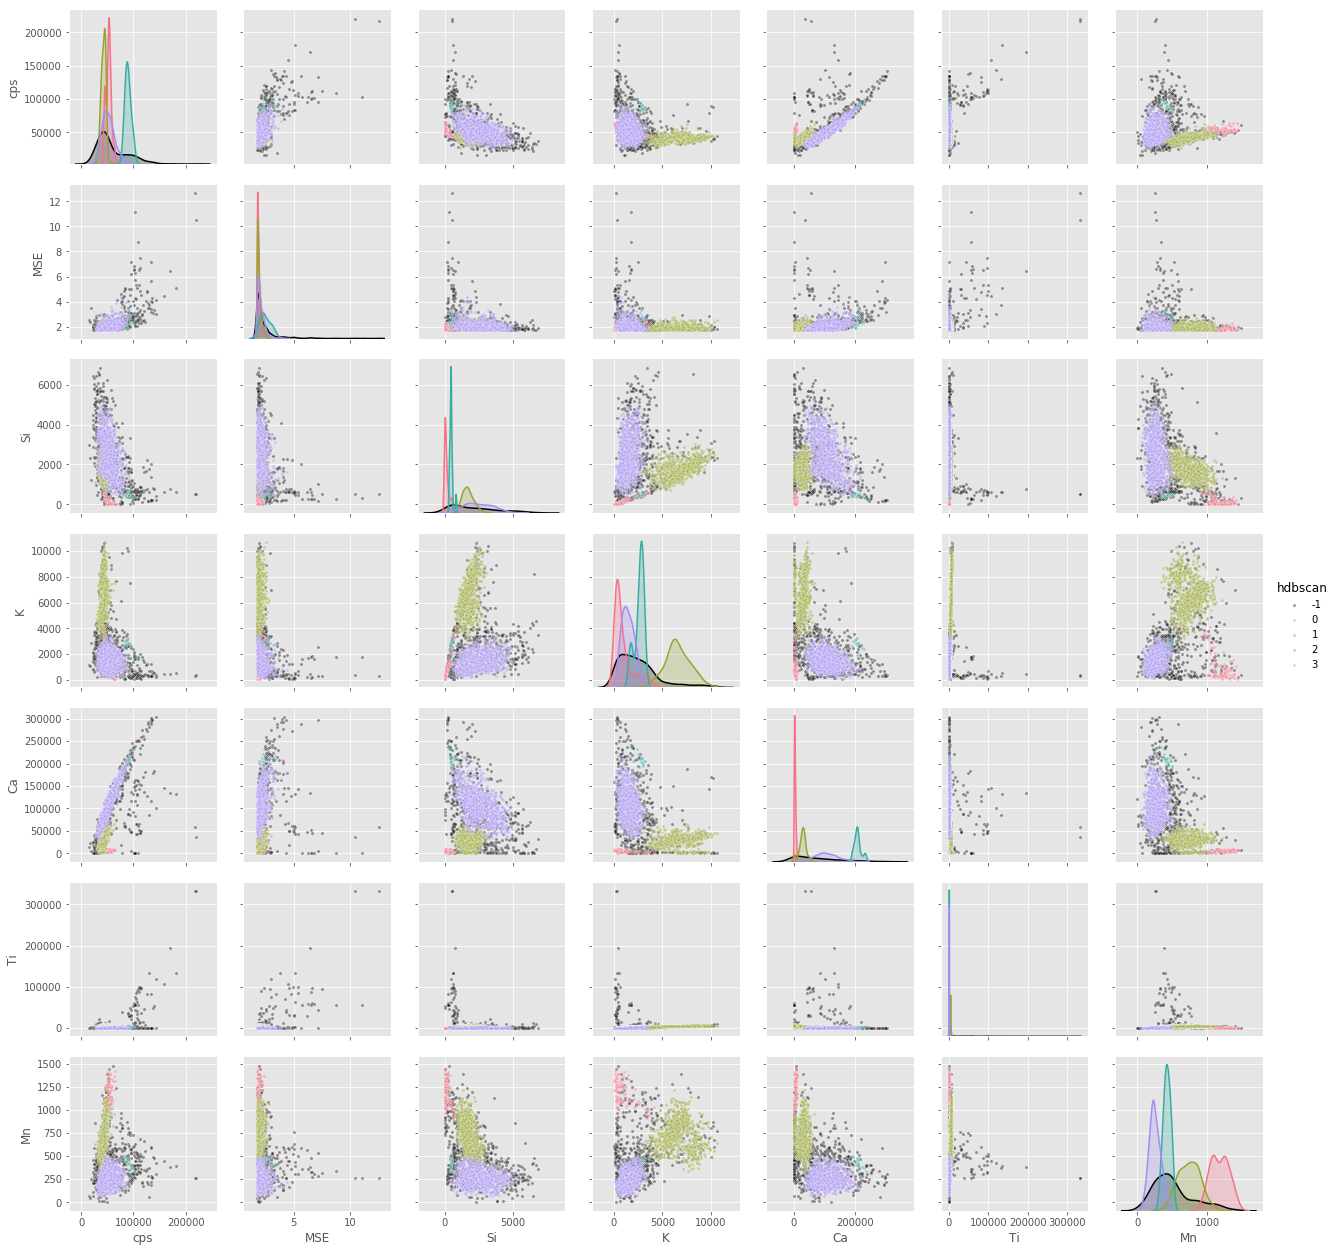

In [ ]:
X_df['hdbscan'] = labels_hdbscan
palette = [(0.0, 0.0, 0.0)] + sns.color_palette('husl', X_df.hdbscan.max() + 1)

g = sns.pairplot(X_df, hue = 'hdbscan', vars = X_df.columns[:-2], palette = palette,
                plot_kws=dict(s=10, linewidth=0.5, alpha = 0.4),
                )

for cluster in np.sort(X_df.hdbscan.unique()):
  print('C{}: {} data points'.format(cluster, len( X_df.groupby('hdbscan').get_group(cluster)) ))

Because I did filter out the the data points that are probably cracks. I would like to see what are all the data points. hdbscan gathers the broad range of data points distinguished as noise. This is not a clear way to see how they are different, so I prefer the algorithms are not noise-free. Even if there are some noise existing, I want to check the differenet characteristic noise respectively.

### Ward's

In [ ]:
Z = hierarchy.linkage(X_std, 'ward')

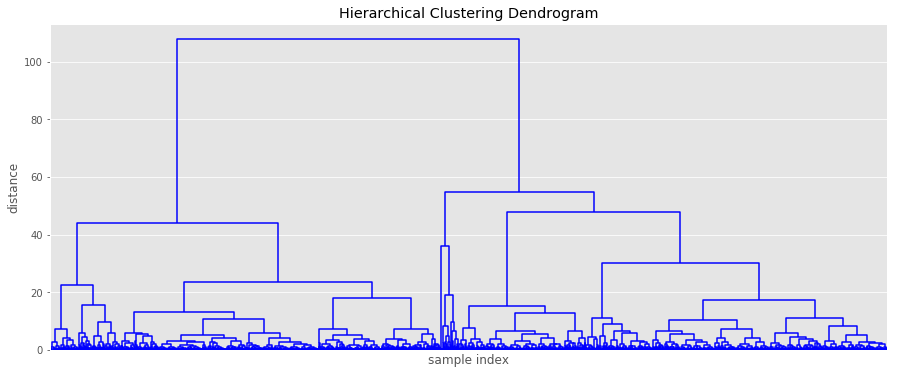

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    no_labels = True,
    color_threshold = 0     # don't separate the clusters yet
)
plt.show()

### calculate the indice in each clustering step

Total sum of squares (TSS)
 
Sum of squares within (SSW)
 
Sum of squares between (SSB) = TSS−SSW
 
Rsquared (RSQ) = SSB/TSS = 1-SSW/TSS

Semi-partial RSQ (SPRSQ) = (SSW - SSW[last step] ) / TSS   The increased SSW compare to last clustering step

In [ ]:
cols = ['Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']
X_std_df = pd.DataFrame(X_std, columns = cols)

TSS = 0
RSQ = []
SPRSQ = []
index = []

for feature in cols:
  TSS += np.sum(
      (X_std_df[feature] - X_std_df[feature].mean())**2
  )
  
SSW = 0 # the fake SSW for calculating the first SPRSQ
for num_cluster in range(12, 0, -1):
  SSW_p = SSW
  SSW = 0
  
  labels_ward = pd.Series(
        hierarchy.fcluster(Z, t = num_cluster, criterion = 'maxclust'),
        name = 'labels_ward'
        )
  
  X_std_df['ward'] = labels_ward
  
  for cluster in np.sort(labels_ward.unique()):
    S_df = X_std_df.groupby('ward').get_group(cluster)
    
    for feature in cols:
      SSW += np.sum(
          (S_df[feature] - S_df[feature].mean())**2
      )
      

  RSQ.append(1 - SSW/TSS)
  SPRSQ.append( (SSW - SSW_p) / TSS )
  index.append(num_cluster)
  
del S_df

In [ ]:
clustering_indice = pd.DataFrame(dict(RSQ = RSQ, SPRSQ = SPRSQ), index = index)

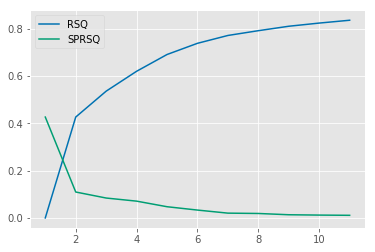

In [ ]:
clustering_indice.loc[11:1].plot()

Based on the dendrogram and indice plot, I decide to choose 5 as the cluster amount.

In [ ]:
labels_ward = pd.Series(
      hierarchy.fcluster(Z, t = 5, criterion = 'maxclust'),
      name = 'labels_ward'
      )
cols = ['Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']
X_std_df = pd.DataFrame(X_std, columns = cols)
X_std_df['ward'] = labels_ward

labels_ward.index = X_df.index
X_df['ward'] = labels_ward

### plot the clustering result in the standardized space

C1: 191 data points
C2: 868 data points
C3: 49 data points
C4: 344 data points
C5: 818 data points


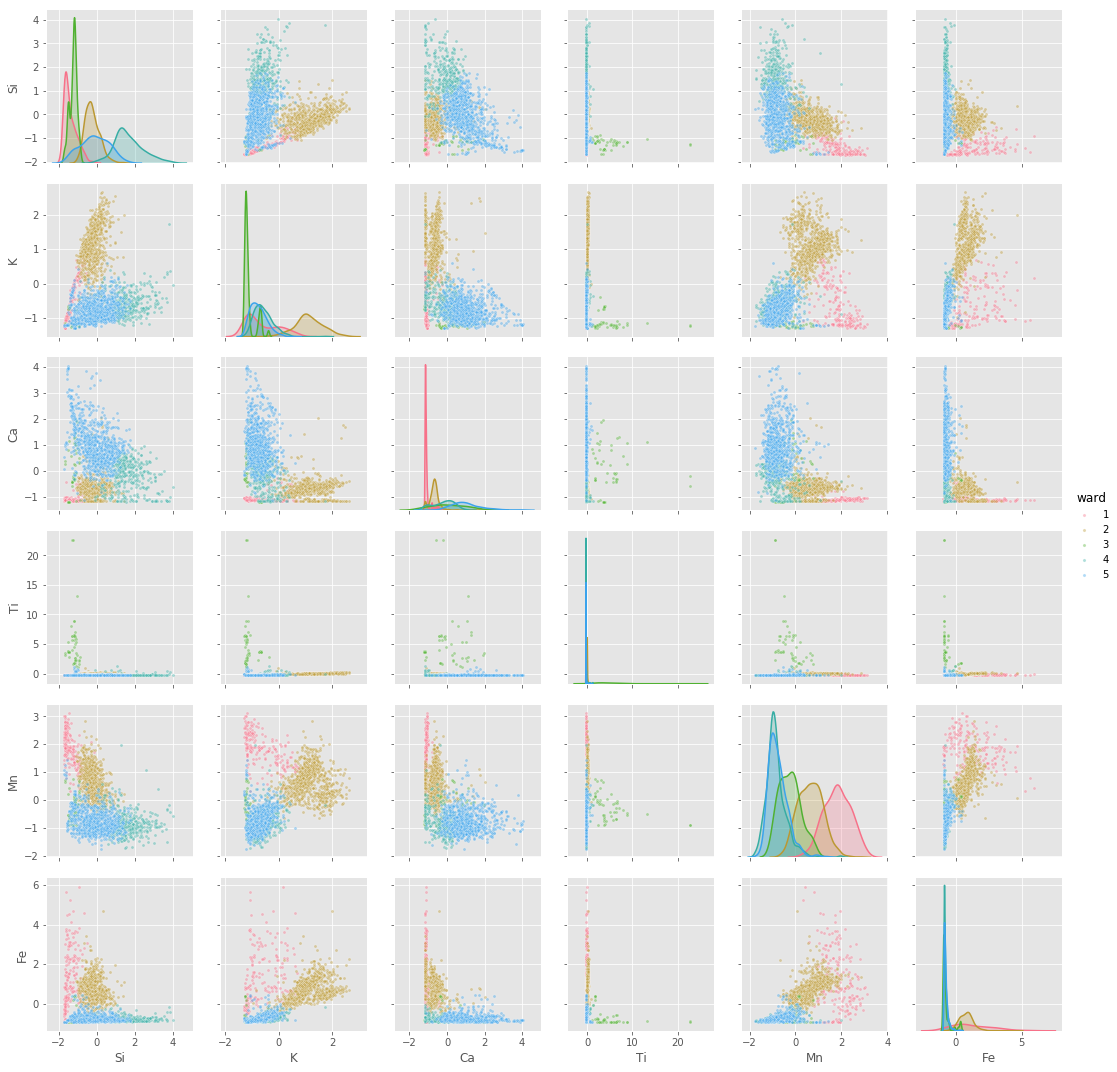

In [ ]:
palette = sns.color_palette('husl', X_std_df.ward.max() + 1)

g = sns.pairplot(X_std_df, hue = 'ward', vars = X_std_df.columns[:-1], palette = palette,
                plot_kws=dict(s=10, linewidth=0.5, alpha = 0.4),
                )

for cluster in np.sort(X_std_df.ward.unique()):
  print('C{}: {} data points'.format(cluster, len( X_std_df.groupby('ward').get_group(cluster)) ))

C:\Users\An-Sheng\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


C1: 191 data points
C2: 868 data points
C3: 49 data points
C4: 344 data points
C5: 818 data points


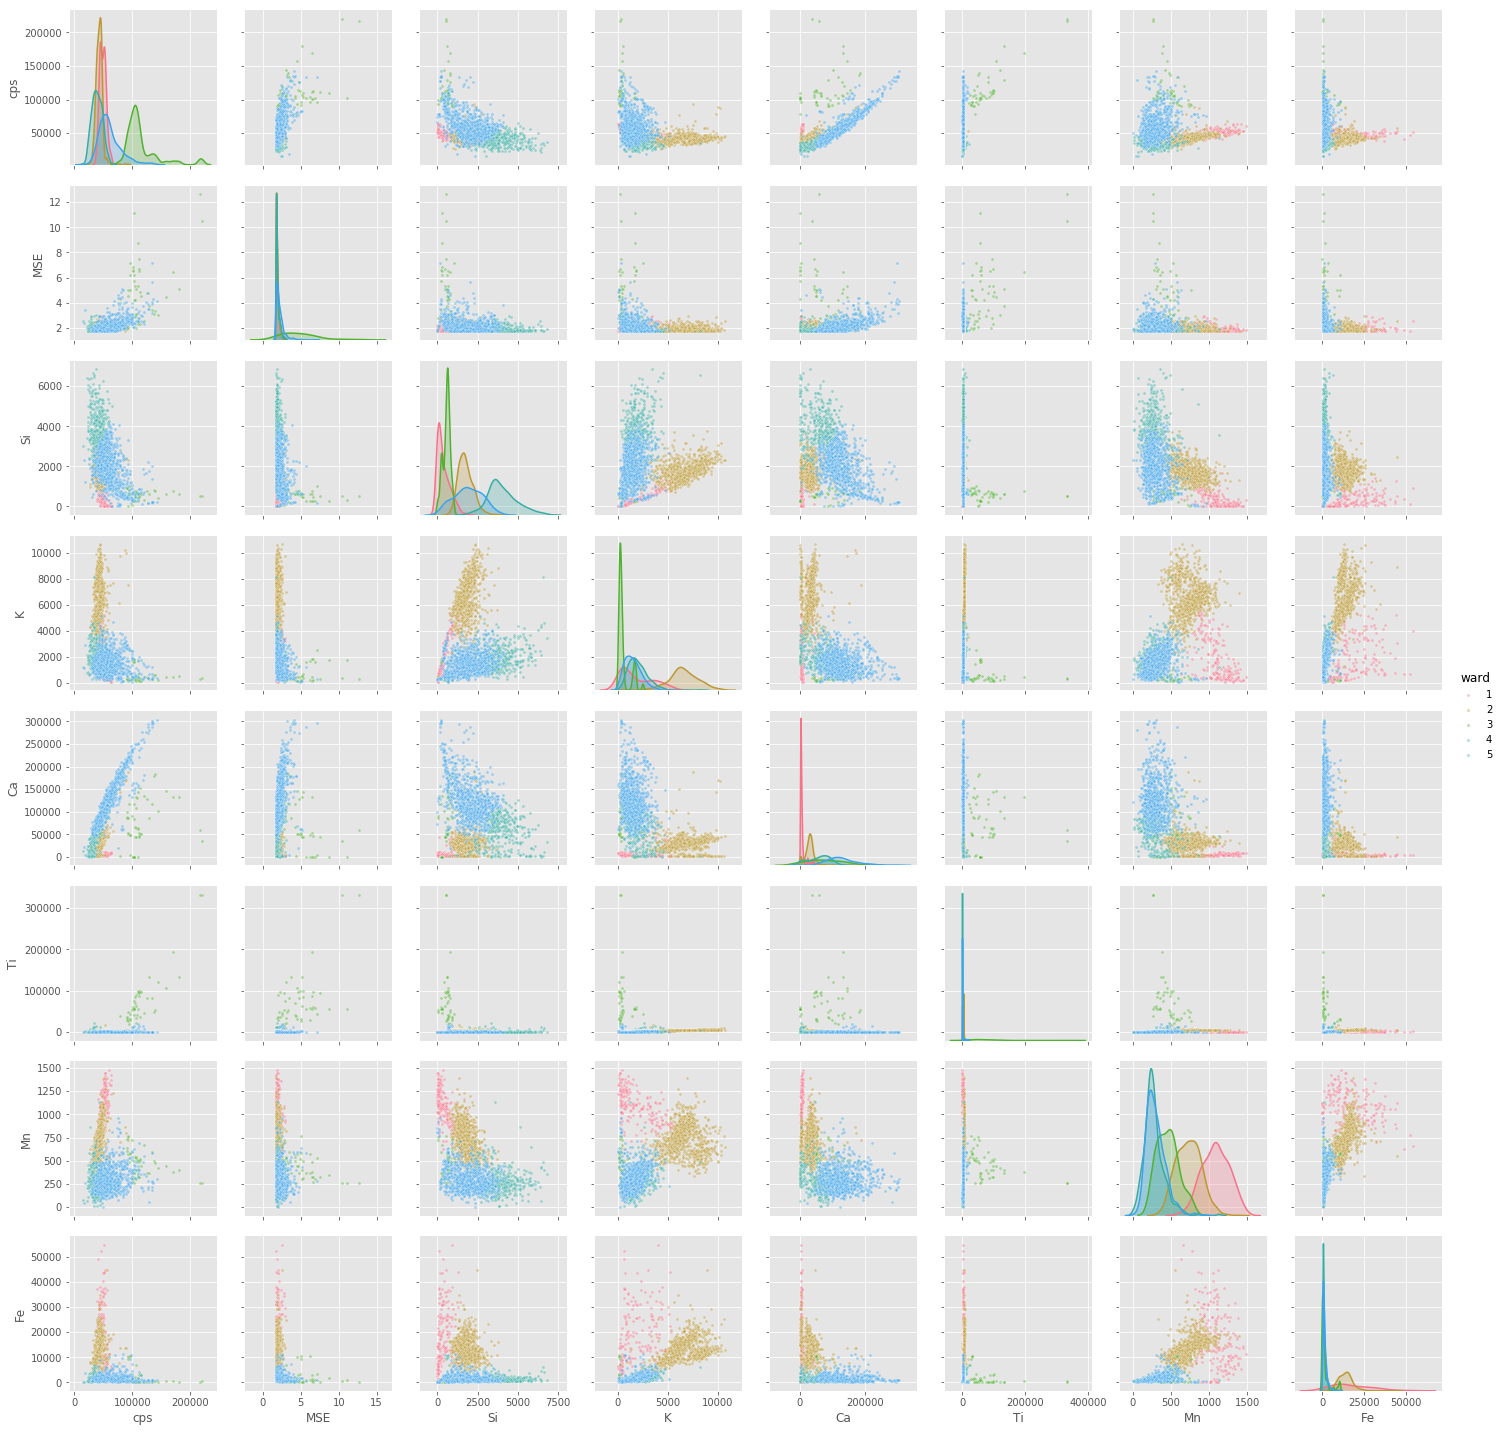

In [ ]:
palette = sns.color_palette('husl', X_df.ward.max() + 1)

g = sns.pairplot(X_df, hue = 'ward', vars = X_df.columns[:-2], palette = palette,
                plot_kws=dict(s=10, linewidth=0.5, alpha = 0.4),
                )

for cluster in np.sort(X_df.ward.unique()):
  print('C{}: {} data points'.format(cluster, len( X_df.groupby('ward').get_group(cluster)) ))

### kmeans

Since I can apply the Ward's clustering analysis to the data and evaluate the cluster number by self-written RSQ and SPRSQ, the Kmeans clustering is put overed.

[blog for calculate sum of squated distances in Kmeans](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [ ]:
Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    L = KMeans(n_clusters=k).fit(X_std)
    Sum_of_squared_distances.append(L.inertia_)

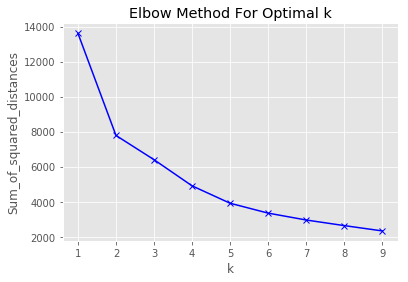

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## let's find out what kind of sediments those have high MSE in the first reprocess are

In [ ]:
results_df['ward'] = 0   # set the bulk sediments as C0
results_df.update(X_df)  # update the ward's labels (C1-C5)
results_df.ward = results_df.ward.astype('int')

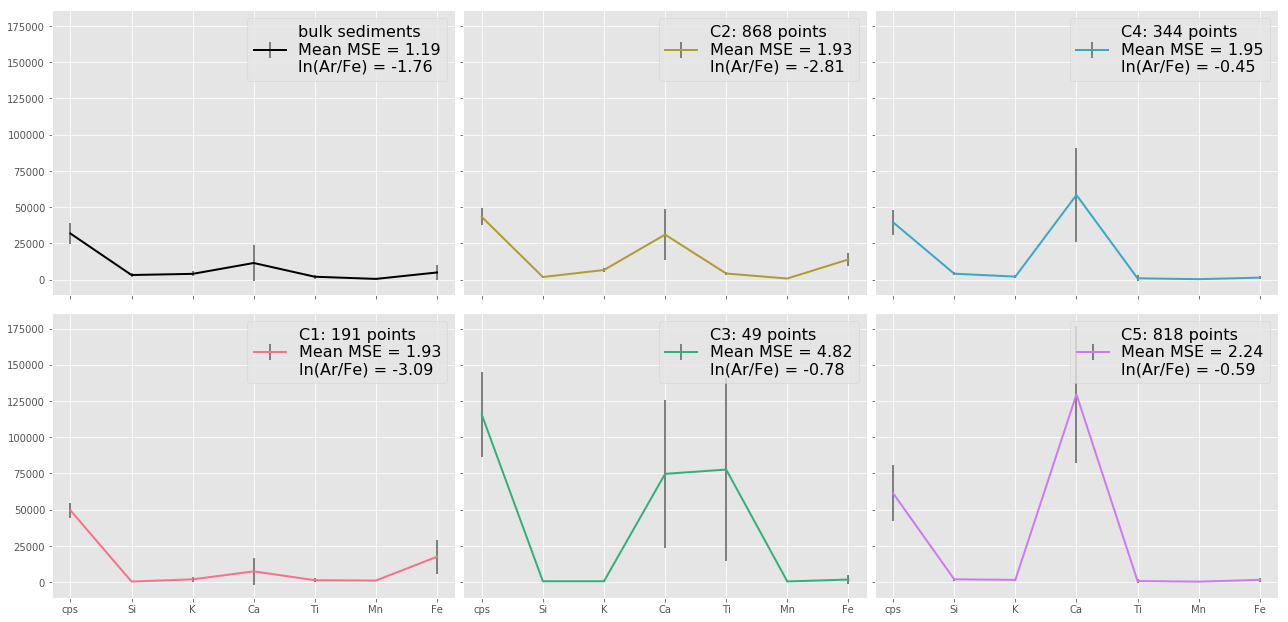

In [ ]:
palette = sns.color_palette('husl', results_df.ward.max())

fig, ax = plt.subplots(2, 3, sharex = True, sharey = True, figsize = (18, 9))
for cluster in np.sort(results_df.ward.unique()):
    
    data = results_df.groupby('ward').get_group(cluster).iloc[:, :-1].describe()
    
    # log scale
    #mean = np.log10(data.loc['mean', ['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']]).replace([np.inf, -np.inf], 0)
    #std = np.log10(data.loc['std', ['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']]).replace([np.inf, -np.inf], 0)
    
    # raw data
    mean = data.loc['mean', ['cps', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']]
    std = data.loc['std', ['cps', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']]

    if cluster == 0:
      color = (0.0, 0.0, 0.0)
      label = 'bulk sediments\nMean MSE = {:03.2f}\nln(Ar/Fe) = {:03.2f}'.format(data.loc['mean', 'MSE'], np.log(data.loc['mean', 'Ar']/ data.loc['mean', 'Fe']))
    else:
      color = palette[cluster-1]
      label = 'C{}: {:.0f} points\nMean MSE = {:03.2f}\nln(Ar/Fe) = {:03.2f}'.format(cluster, data.loc['count'][0], data.loc['mean', 'MSE'],  np.log(data.loc['mean', 'Ar']/ data.loc['mean', 'Fe']))
    
    if cluster < 2:
      ax[cluster, 0].errorbar(
              x = mean.index, 
              y = mean, 
              yerr = std, ecolor = 'grey', 
              c = color, label = label, linewidth = 2
              )
      ax[cluster, 0].legend(fontsize = 16, markerscale = 4)

    elif cluster < 4:
      ax[cluster-2, 1].errorbar(
              x = mean.index, 
              y = mean, 
              yerr = std, ecolor = 'grey', 
              c = color, label = label, linewidth = 2
              )
      ax[cluster-2, 1].legend(fontsize = 16, markerscale = 4)
      
    else:
      ax[cluster-4, 2].errorbar(
              x = mean.index, 
              y = mean, 
              yerr = std, ecolor = 'grey', 
              c = color, label = label, linewidth = 2
              )
      ax[cluster-4, 2].legend(fontsize = 16, markerscale = 4)
      
fig.tight_layout()
fig.subplots_adjust(wspace = 0.02, top = 0.95)

Comparing to the bulk sediments:

(1) C1 is generally similar, but slightly higher in cps, MSE and Fe

(2) C2, C4, C5 are higher in cps, MSE and Ca. These three analytes jointly increase to separated these three clusters. However, the higher ln(Ar/Fe) may idicate C4 and C5 are scanning of cracks.

(3) C3 has the fewest number of datapoints, significantly highest value in cps and Ti, and higher value in Ca and ln(Ar/Fe). It's unique but I think probably not the sediments, more like cracks.

(4) none of them has the peat characteristics (clearly low Si, K, Ca, and high Mn) indicated by Francesca's thesis. and is continuesly as a layer of face.

## check the core photos

In [ ]:
##### read a table for core_section and orginal depth
info_df = pd.DataFrame({
    'ID': pd.read_csv('database\\info.cleaned.ID.csv', squeeze = True),
    'section': pd.read_csv('database\\info.cleaned.core_section.csv', squeeze = True),
    'position_mm': pd.read_csv('database\\info.cleaned.original_depth_mm.csv', squeeze = True)
})

In [ ]:
cluster = 5 # select  the cluster
sel_ID = []
for dir in results_df.groupby('ward').get_group(cluster).reset_index(drop = True).filename:
  core_id, com_depth = dir.split('\\')[-1].split('_')[1:]
  sel_ID.append('{}_{}'.format(core_id, com_depth[:-4]))

info_df[info_df['ID'].isin(sel_ID)]

ID  section  position_mm
127       N10_003702    N10-1       262.00
495       N10_004444    N10-1      1004.00
513       N10_004490    N10-1      1050.00
514       N10_004492    N10-1      1052.00
795       N10_002915    N10-2       575.00
796       N10_002917    N10-2       577.00
797       N10_002919    N10-2       579.00
798       N10_002921    N10-2       581.00
2169      N11_002757    N11-1        32.00
2200      N11_002819    N11-1        94.00
2754      N11_001814    N11-2       189.00
2853      N11_002110    N11-2       485.00
2854      N11_002112    N11-2       487.00
2856      N11_002116    N11-2       491.00
2858      N11_002120    N11-2       495.00
3712      N11_000092    N11-4       152.00
3956      N12_002965    N12-1       130.00
3964      N12_002981    N12-1       146.00
3966      N12_002985    N12-1       150.00
3967      N12_002987    N12-1       152.00
3971      N12_002995    N12-1       160.00
3978      N12_003015    N12-1       180.00
3990      N12_003045    N12-1       210.00
4231      N12_003531    N12-1       696.00
4232      N12_003533    N12-1       698.00
4233      N12_003535    N12-1       700.00
4236      N12_003541    N12-1       706.00
4237      N12_003543    N12-1       708.00
4238      N12_003545    N12-1       710.00
4239      N12_003547    N12-1       712.00
...              ...      ...          ...
164143    N23_000167    N23-5      1232.00
164144    N23_000169    N23-5      1234.00
164151    N23_000219    N23-5      1284.00
164152    N23_000221    N23-5      1286.00
164153    N23_000223    N23-5      1288.00
164159    N23_000241    N23-5      1306.00
164196    N23_000345    N23-5      1410.00
164312    N27_000607    N27-4       212.00
164320    N27_000623    N27-4       228.00
164339    N27_000663    N27-4       268.00
164340    N27_000665    N27-4       270.00
164341    N27_000667    N27-4       272.00
167337  VVC19_000370  VVC19-4       240.00
167475  VVC19_000670  VVC19-4       540.00
167731  VVC19_001256  VVC19-4      1126.00
167741  VVC19_001276  VVC19-4      1146.00
167742  VVC19_001278  VVC19-4      1148.00
170168  VVC07_000228  VVC07-4       228.39
170170  VVC07_000242  VVC07-4       242.39
170173  VVC07_000248  VVC07-4       248.39
170178  VVC07_000258  VVC07-4       258.39
170179  VVC07_000260  VVC07-4       260.39
170184  VVC07_000272  VVC07-4       272.39
170188  VVC07_000284  VVC07-4       284.39
170189  VVC07_000286  VVC07-4       286.39
170194  VVC07_000346  VVC07-4       346.39
170284  VVC07_000542  VVC07-4       542.39
170311  VVC07_000600  VVC07-4       600.39
170312  VVC07_000602  VVC07-4       602.39
170313  VVC07_000604  VVC07-4       604.39

[818 rows x 3 columns]

C3 is considered the group of datapoints reflecting the color chart, so can be excluded. Surprisingly there are still some points of color chart left after the previous filtering.

C4 and C5 are the scannings of rough surface related to shell layers. C5 is rougher than C4.

C1 and 2 have no clear sign of being cracks. Maybe they indicate the Ca or Fe rich sediments, or shell fragments.

## reprocess C1 and C2

Let's reprocess C1 and C2 to see if the re-fitting helps.

In [ ]:
spe_dirs = (results_df.groupby('ward').get_group(1).filename
            .append(results_df.groupby('ward').get_group(2).filename)
            .reset_index(drop = True)
           )

In [ ]:
tdir = path+'\\XRF\\data_shuffled'
row = 0

# if the directory isn't create, create one 
if os.path.exists(tdir + '\\ac1+2') == False:
  os.makedirs(tdir + '\\ac1+2' , 0o775)
content_sum = np.zeros((1024,), dtype = int)
        
for spe_dir in spe_dirs:
  content = []
  file = spe_dir.split('\\')[-1]
  new_spe = tdir + '\\ac1+2\\' + file        
  shutil.copy(spe_dir, new_spe)

  ## read spe   
  with open(spe_dir, 'r') as f:
    lines = f.readlines()
    ## copy the header of the first spe as the sumspectrum's header
    if row == 0:
      header = lines[:38]
      row += 1       
                
    ## channel content in spectrum
    for txt in lines[38:]:
       content.append( int( txt.split('\t')[1].split('\n')[0] ))     
                
    content_sum += content
     
## write the sumspectrum
sum_dir = tdir + '\\sumspectra\\ac1+2_sumspectrum.spe'
       
## The previous sumspectrum (if exists) need to be deleted because I use append mode for writing
if os.path.isfile(sum_dir):
    os.remove(sum_dir)
    
with open(sum_dir, 'a') as f_out:
    for _ in header:
        print(_, end = '', file = f_out)
    for channel, content in enumerate(content_sum):
        print('{}\t{}'.format((channel + 1), content), file = f_out)

### reprocess result
The c1 and c2 (P.S. don't mess up with the random clustering 7 labels) were jointly reprocessed again with their own sumspectrum. Actually I didn't do many mannual adjustments for the fitting to reach the lowest MSE. I used the same setting (WASA_settings_whole_i1_20190428.dfl) and green bottom once only to have the best fitting. The max. iteration is set to 5 same as before.

No other elements are added and no parameters were chaged significantly. In other words, those sediments are still similar to the bulk sediments due to the bare adjustment. 

In [ ]:
c1c2_df = pd.read_table('XRF\\data_shuffled\\Results_shuffled_i5_ac1+2.txt', skiprows = 2).drop('Unnamed: 59', axis = 1)
c1c2_df.describe().MSE

count    1059.000000
mean        1.182427
std         0.125837
min         0.970000
25%         1.110000
50%         1.160000
75%         1.220000
max         2.420000
Name: MSE, dtype: float64

In [ ]:
c1c2_df[c1c2_df.MSE > 2].iloc[:, 7:30]

F-offset    cps   MSE  Mg  Al    Si   P    S    Cl   Ar ...    Ti   V  \
80   0.094006  34082  2.42  27  88  2499  36  611  2140  957 ...  4542   0   
714  0.094006  31226  2.15   6  94  1564   9  130  1199  856 ...  3561  19   

      Mn     Fe  Ni  Cu  Zn  Ga  As  Se  
80   342   8227  59  36  48  97   0   0  
714  515  12057  45  74  63  99  19   0  

[2 rows x 23 columns]

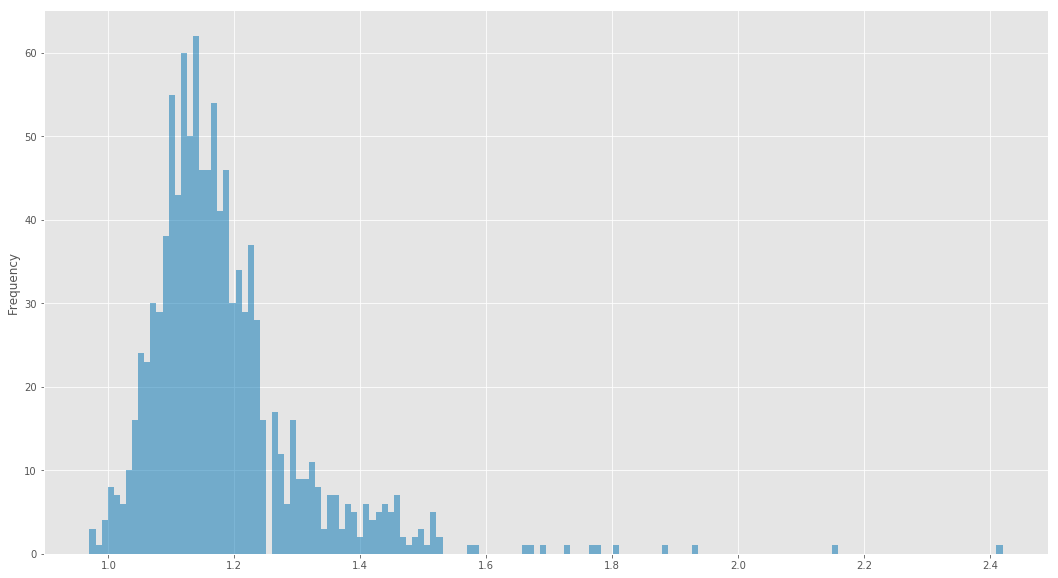

In [ ]:
c1c2_df['MSE'].plot(kind = 'hist', alpha = 0.5, figsize = (18, 10), bins = 150)

Only 2 data points have MSE higher than 2 in the histogram. The major distribution centerizes around 1.2. I prefer to exclude those points have MSE higher than 3 std.

## reprocess C4 and C5

Let's reprocess C4 and C5 to see if the re-fitting helps. They are processed together because they both caused by the roughness of chell layer but with different levels.

In [ ]:
spe_dirs = (results_df.groupby('ward').get_group(4).filename
            .append(results_df.groupby('ward').get_group(5).filename)
            .reset_index(drop = True)
           )

In [ ]:
tdir = path+'\\XRF\\data_shuffled'
row = 0

# if the directory isn't create, create one 
if os.path.exists(tdir + '\\ac4+5') == False:
  os.makedirs(tdir + '\\ac4+5' , 0o775)
content_sum = np.zeros((1024,), dtype = int)
        
for spe_dir in spe_dirs:
  content = []
  file = spe_dir.split('\\')[-1]
  new_spe = tdir + '\\ac4+5\\' + file        
  shutil.copy(spe_dir, new_spe)

  ## read spe   
  with open(spe_dir, 'r') as f:
    lines = f.readlines()
    ## copy the header of the first spe as the sumspectrum's header
    if row == 0:
      header = lines[:38]
      row += 1       
                
    ## channel content in spectrum
    for txt in lines[38:]:
       content.append( int( txt.split('\t')[1].split('\n')[0] ))     
                
    content_sum += content
     
## write the sumspectrum
sum_dir = tdir + '\\sumspectra\\ac4+5_sumspectrum.spe'
       
## The previous sumspectrum (if exists) need to be deleted because I use append mode for writing
if os.path.isfile(sum_dir):
    os.remove(sum_dir)
    
with open(sum_dir, 'a') as f_out:
    for _ in header:
        print(_, end = '', file = f_out)
    for channel, content in enumerate(content_sum):
        print('{}\t{}'.format((channel + 1), content), file = f_out)

### reprocess result
The c4 and c5 (P.S. don't mess up with the random clustering 7 labels) were jointly reprocessed again with their own sumspectrum. I used the same setting (WASA_settings_whole_i1_20190428.dfl) as the start. The MSE is 5 times of the c1+c2. Several misfittings can clearly be seen, especially the Ar peak. The fitting curve is way lower than the actual signature. This time besided the finetune, I exclude Sc in the element table. The max. iteration is set to 5 same as before.

In [ ]:
c4c5_df = pd.read_table('XRF\\data_shuffled\\Results_shuffled_i5_ac4+5.txt', skiprows = 2).drop('Unnamed: 58', axis = 1)
c4c5_df.describe().MSE

count    1162.000000
mean        1.704836
std         0.355724
min         1.050000
25%         1.490000
50%         1.630000
75%         1.830000
max         4.790000
Name: MSE, dtype: float64

In [ ]:
c4c5_df.shape

(1162, 58)

In [ ]:
c4c5_df[c4c5_df.MSE > 2].iloc[:, 7:30]

F-offset     cps   MSE  Mg   Al    Si   P     S    Cl    Ar  ...     V  \
1      0.09814   70683  2.02  25   93  1192   0   382   387   889  ...     8   
3      0.09814   98853  2.04  19  110   458   0   110   788  1017  ...    89   
6      0.09814   94813  2.02   0  103  1640   0    95  1491   994  ...    21   
19     0.09814   21873  2.16   0   58  6391  19    31   524   765  ...    61   
25     0.09814   18910  3.48   0   22  1207   0    52  1219   708  ...     0   
38     0.09814   26160  2.01   0   42  2342   0    73   940   823  ...   114   
42     0.09814   70704  2.12  14   96  1053   0    29  1043   827  ...     0   
44     0.09814   77843  2.08  15   79  3413   0     0   625   927  ...    49   
45     0.09814   83183  3.91  18  117   665  45  2992  1279   849  ...     0   
46     0.09814   28813  2.04   0   49  3838  10    97  2639   729  ...   113   
57     0.09814  134740  3.84  40  128   280   0   527  1865   951  ...    48   
59     0.09814   85189  2.03  15  101  1997   0    89  1196  1222  ...    32   
60     0.09814  133921  3.12  13  119  1426   0   136  1484   884  ...    16   
89     0.09814   72072  2.13  34  105  3205   0   225  1249   891  ...    61   
92     0.09814   96152  2.25  13  119  1807   0   136  2335   930  ...    62   
94     0.09814   97549  2.22   0   85  1269   0   210  1545   941  ...    66   
100    0.09814   71711  2.18  24  109   967   0    39   846   873  ...    60   
105    0.09814  135122  2.96   0  134   269   0   327  2187   988  ...    35   
137    0.09814   16238  2.34   0   14  2333   0    51   650   823  ...    52   
139    0.09814   29382  2.83  17   53  4570   9    54  2135  1021  ...    65   
149    0.09814   91636  2.07  15   93  1730   0    22   838   942  ...    28   
185    0.09814   26934  2.38   0   84  1922  25    79  2101   830  ...    23   
244    0.09814   30971  2.09   6   61  4450   0    55  1430   759  ...    54   
293    0.09814   91883  2.02  19  105  1252   0   298  1875   486  ...    87   
310    0.09814   82162  2.03   8  101  1592   0   178  1114   698  ...    21   
315    0.09814  134200  3.11   0  133   290   0   490  1349   977  ...    50   
333    0.09814  129629  2.83   0  147  1831   0   152  1078   810  ...    33   
351    0.09814   99584  2.29   0   90   377   0    57  1095   786  ...    98   
353    0.09814   15512  2.49  25   48  2988   7     0   271   908  ...    39   
358    0.09814  116686  2.12  14  115   182   0   484  1491   942  ...    21   
...        ...     ...   ...  ..  ...   ...  ..   ...   ...   ...  ...   ...   
1007   0.09814   61545  2.22  30   87  1575   0   216  1346   846  ...     0   
1013   0.09814   66170  2.20   0  136  1528   0   452   630   892  ...    15   
1019   0.09814   28692  2.47   4   65  3731  16   142  2112   907  ...    66   
1020   0.09814   58040  2.09   0  108  2542   0   202  1434   944  ...    71   
1021   0.09814   77188  2.05  22  111  1290   0   457  2418   904  ...    57   
1031   0.09814   77643  2.25   0   74   581   0   110   720  1104  ...    72   
1036   0.09814   71347  2.03   0   79  3439   0   155   864   884  ...     0   
1039   0.09814   52381  2.01  11   84  3163   0    84   733   926  ...    54   
1043   0.09814   63636  2.70   0   99  3561   0    58  1488   973  ...    47   
1048   0.09814   97620  2.47   0   89   926   0   123  1300   782  ...    73   
1051   0.09814   69166  2.02   0   87  2698   0    74  1129  1037  ...    70   
1054   0.09814   48029  2.06   0   25  2248   0    29  1501   904  ...    69   
1056   0.09814  109466  2.56  14  292   698   0   517   400   806  ...     0   
1058   0.09814   63460  2.54  31   93  3928   0    76  1180   823  ...    10   
1064   0.09814   56372  2.46   0   71  1862   0    80  1087   802  ...    94   
1069   0.09814   54225  2.05  25   81  3073   0    96  1052   922  ...     0   
1071   0.09814   57938  2.17   0   89  2673   0    66   477   963  ...     0   
1072   0.09814   77886  2.07  11   85    97   0   203   127   783  ...   234   
1083  

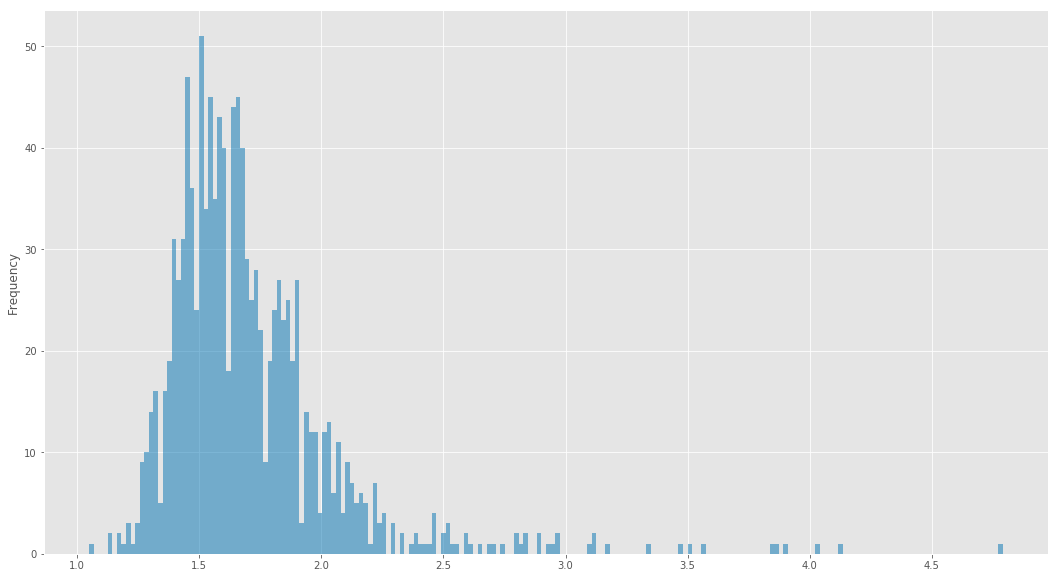

In [ ]:
c4c5_df['MSE'].plot(kind = 'hist', alpha = 0.5, figsize = (18, 10), bins = 200)

Due to the really rough surface, the data quality is poor. The MSE relates to the high Ar peak, so I decide to exclude the points having MSE higher than 3 std.

## Conclude the reprocessed elemental profiles
Take the reprocessed result dataset as the base and filtered out the c1~c5 data points. Append the twice reprocessed data points (c1+c2 - 3 points) back to the dataset.

In [ ]:
print('The shape of all results is {}.'.format(results_df.iloc[:, :-1].shape))

mse = results_df.MSE.mean() + 3 * results_df.MSE.std()
filtered_results_df = results_df[results_df['MSE'] <= mse].iloc[:, :-1].copy()

upper_c1c2 = c1c2_df.MSE.mean() + 3 * c1c2_df.MSE.std()
upper_c4c5 = c4c5_df.MSE.mean() + 3 * c4c5_df.MSE.std()
final_df = (filtered_results_df
            .append(c1c2_df[c1c2_df.MSE <= upper_c1c2], ignore_index = True)
            .append(c4c5_df[c4c5_df.MSE <= upper_c4c5], ignore_index = True))
print('The shape of filtered results is {}.'.format(final_df.shape))

excluded_df = (results_df[results_df['ward'] == 3].iloc[:, :-1].copy()
               .append(c1c2_df[c1c2_df.MSE > upper_c1c2], ignore_index = True)
               .append(c4c5_df[c4c5_df.MSE > upper_c4c5], ignore_index = True))
print('The shape of excluded results is {}.'.format(excluded_df.shape))

The shape of all results is (170557, 59).
The shape of filtered results is (170470, 59).
The shape of excluded results is (87, 59).


Since the Sc values in c4+5 result are all NA, they need to be replaced by 0.

In [ ]:
final_df.Sc.fillna(0, inplace = True)

In [ ]:
final_df.describe().MSE

count    170470.000000
mean          1.188868
std           0.134578
min           0.880000
25%           1.100000
50%           1.160000
75%           1.240000
max           2.750000
Name: MSE, dtype: float64

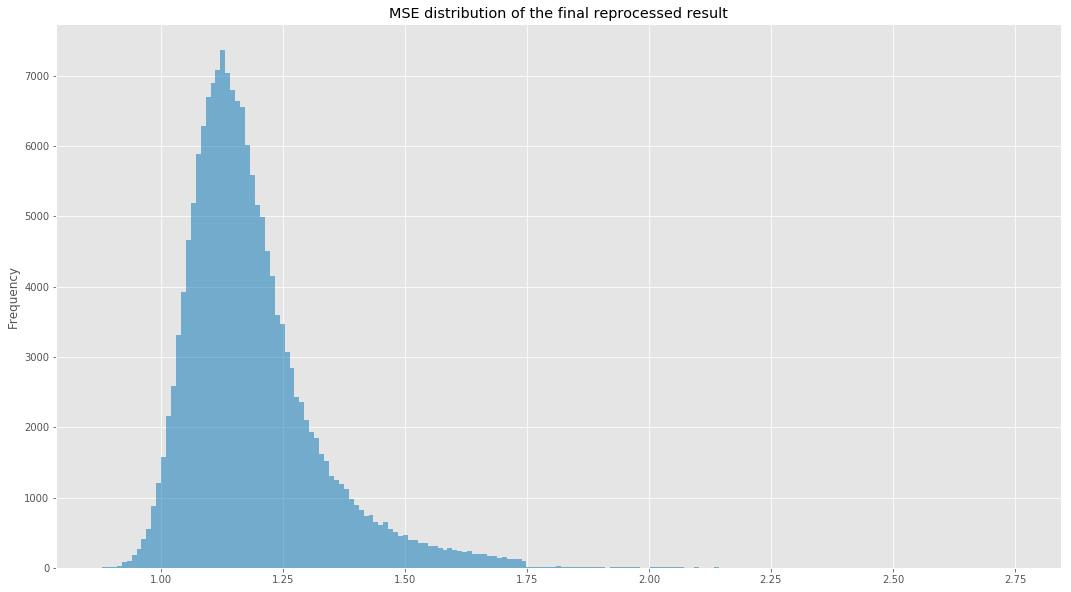

In [ ]:
final_df['MSE'].plot(kind = 'hist', alpha = 0.5, figsize = (18, 10), bins = 185, title = 'MSE distribution of the final reprocessed result')

The distribution reaches nearly normal distribution. Such a beauty.

## export the final results

### export the cleaned dataset
Adopt filename to generate ID, and use it to sort the dataframe because the datapoints were shuffled.

In [ ]:
final_id = []
for row in range(len(final_df)):
  file = final_df.filename[row].split('\\')[-1].split('_')
  if len(file) == 3:
    core_id, last = file[1:]
  else:
    core_id, last = file
      
  final_id.append(core_id + '_' + last[:-4])
  
final_df['composite_id'] = final_id
final_df.sort_values(by = ['composite_id'], inplace = True)

In [ ]:
pre_cl_info = pd.DataFrame({'composite_id': pd.read_csv('database\\info.cleaned.ID.csv', squeeze = True),
                           'core_id': pd.read_csv('database\\info.cleaned.core_ID.csv', squeeze = True),
                           'core_section': pd.read_csv('database\\info.cleaned.core_section.csv', squeeze = True),
                           'composite_depth_mm': pd.read_csv('database\\info.cleaned.composite_depth_mm.csv', squeeze = True),
                           'original_depth_mm': pd.read_csv('database\\info.cleaned.original_depth_mm.csv', squeeze = True),
                           'composite_spe_dir': pd.read_csv('database\\info.cleaned.composite_spe_dir.csv', squeeze = True),
                           'data_original_dir': pd.read_csv('database\\info.cleaned.data_original_dir.csv', squeeze = True)})

merge_cleaned_df = pd.merge(final_df, pre_cl_info, how = 'inner', on = 'composite_id')

In [ ]:
print(len(final_df))
print(len(merge_cleaned_df))

170470
170470


In [ ]:
cols = []
for col in merge_cleaned_df.columns:
  cur = col.replace(' ', '_').replace('(', '').replace(')', '')
  cols.append(cur)

In [ ]:
merge_cleaned_df.columns = cols

In [ ]:
merge_cleaned_df.iloc[:, : -7].to_csv('database\\XRF_results.cleaned.all.csv', index = False)

for col in merge_cleaned_df.columns[:-7]:
  merge_cleaned_df[col].to_csv('database\\XRF_results.cleaned.{}.csv'.format(col), index = False)
for col in merge_cleaned_df.columns[-7:]:
  merge_cleaned_df[col].to_csv('database\\info.cleaned.{}.csv'.format(col), index = False)

### export the excluded dataset
Adopt filename to generate ID, and use it to sort the dataframe because the datapoints were shuffled.

#### the excluded dataset of this time

In [ ]:
excluded_id = []
for row in range(len(excluded_df)):
  core_id, last = excluded_df.filename[row].split('\\')[-1].split('_')[1:]    
  excluded_id.append(core_id + '_' + last[:-4])
  
excluded_df['composite_id'] = excluded_id
excluded_df.sort_values(by = ['composite_id'], inplace = True)

In [ ]:
now_ex_df = pd.merge(pre_cl_info, excluded_df, how = 'inner', on = 'composite_id')
now_ex_df.shape

(87, 66)

In [ ]:
now_ex_df.columns

Index(['composite_id', 'core_id', 'core_section', 'composite_depth_mm',
       'original_depth_mm', 'composite_spe_dir', 'data_original_dir', 'Al',
       'Ar', 'As', 'Ba', 'Bi', 'Br', 'Ca', 'Ca ka Cr ka', 'Ca ka+ Ca  ka',
       'Ca ka+Ca kb', 'Ca ka+Fe ka', 'Cl', 'Cr coh', 'Cr inc', 'Cr_add', 'Cs',
       'Cu', 'Dt', 'E-gain', 'E-offset', 'F-offset', 'F-slope', 'Fe', 'Ga',
       'Ho', 'K', 'La', 'MSE', 'Mg', 'Mn', 'Ni', 'P', 'Pb', 'Pd', 'Rb', 'S',
       'S1', 'S2', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ti', 'Tm', 'V', 'W',
       'W La scat', 'W Lb1 scat', 'W la', 'W lb1', 'W lb2', 'Zn', 'Zr', 'cps',
       'filename', 'position (mm)', 'sample surface', 'validity'],
      dtype='object')

In [ ]:
# modify the column names
cols = []
for col in now_ex_df.columns:
  cur = col.replace(' ', '_').replace('(', '').replace(')', '')
  cols.append(cur)

now_ex_df.columns = cols

# give a memo as the reason column
now_ex_df['reasons'] = ['is is excluded by pre-reprocess_workflow.ipynb' for _ in range(len(now_ex_df))]

In [ ]:
now_ex_df.shape

(87, 67)

#### the previouse excluded dataset 

In [ ]:
pre_ex_df = pd.read_csv('database\\XRF_results.excluded.all.csv')
pre_ex_df.shape

(16487, 59)

In [ ]:
pre_ex_id = []

for row in range(len(pre_ex_df)):
  pre_ex_id.append(
      pre_ex_df.new_spe_dir[row].split('\\')[-1][:-4]
  )

pre_ex_df['composite_id'] = pre_ex_id

pre_ex_df.shape

(16487, 60)

In [ ]:
pre_ex_df.columns

Index(['position (mm)', 'sample surface', 'validity', 'E-gain', 'E-offset',
       'F-slope', 'F-offset', 'cps', 'MSE', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
       'Ar', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge',
       'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Pd', 'Sb', 'Ba', 'La', 'Pb', 'Th',
       'S1', 'Ca ka+ Ca  ka', 'Ca ka+Ca kb', 'Ca ka+Fe ka', 'Ca ka Cr ka',
       'S2', 'W la', 'W lb1', 'W lb2', 'W La scat', 'W Lb1 scat', 'Cr inc',
       'Cr coh', 'Dt', 'core_ID', 'core_section', 'composite_depth_mm',
       'data_original_dir', 'new_spe_dir', 'reasons', 'composite_id'],
      dtype='object')

In [ ]:
# modify the column names
cols = []
for col in pre_ex_df.columns:
  cur = col.replace(' ', '_').replace('(', '').replace(')', '')
  cols.append(cur)

cols[-3] = 'composite_spe_dir'
cols[-7] = 'core_id'
pre_ex_df.columns = cols
pre_ex_df['original_depth_mm'] = pre_ex_df.position_mm # in order to be consistent to the later dataset, I copy the original_depth_mm from position_mm

In [ ]:
pre_ex_df.columns

Index(['position_mm', 'sample_surface', 'validity', 'E-gain', 'E-offset',
       'F-slope', 'F-offset', 'cps', 'MSE', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
       'Ar', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge',
       'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Pd', 'Sb', 'Ba', 'La', 'Pb', 'Th',
       'S1', 'Ca_ka+_Ca__ka', 'Ca_ka+Ca_kb', 'Ca_ka+Fe_ka', 'Ca_ka_Cr_ka',
       'S2', 'W_la', 'W_lb1', 'W_lb2', 'W_La_scat', 'W_Lb1_scat', 'Cr_inc',
       'Cr_coh', 'Dt', 'core_id', 'core_section', 'composite_depth_mm',
       'data_original_dir', 'composite_spe_dir', 'reasons', 'composite_id',
       'original_depth_mm'],
      dtype='object')

#### merge the excluded dfs to export

In [ ]:
set(now_ex_df.columns) - set(pre_ex_df.columns)

{'Bi', 'Cr_add', 'Cs', 'Ho', 'Sc', 'Se', 'Sn', 'Tm', 'W', 'filename'}

Those analytes were added while reprocessing except filename. In this dataframe, the 'data_original_dir' is much important than filename, so I'm going to leave those columns NAs.

In [ ]:
merge_excluded_df = now_ex_df.append(pre_ex_df, ignore_index = True)

In [ ]:
merge_excluded_df.shape

(16574, 71)

Instead of exporting into column by column, for excluded dataset I just export them into one csv.

In [ ]:
merge_excluded_df.to_csv('database\\XRF_results.excluded.all.csv', index = False)

# Some tries but probably not going to be used.

## Kmeans culstering
8 analytes are included for the clustering.

In [ ]:
S_df = results_df[['cps', 'MSE', 'Si', 'K', 'Ca', 'Ti', 'Mn', 'Fe']]

### Compute the Silhouette score of all samples to determine the number of clusters
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and 
the mean nearest-cluster distance (b) for each sample. 
The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
The best value is 1 and the worst value is -1.

processing the result of 2 clusters.
processing the result of 3 clusters.
processing the result of 4 clusters.
processing the result of 5 clusters.
processing the result of 6 clusters.
processing the result of 7 clusters.
processing the result of 8 clusters.
processing the result of 9 clusters.
The loops of Sklearn KMeans & silhouette totally take 58.9 mins


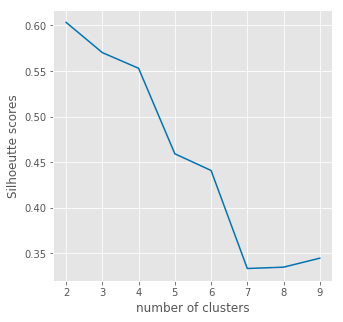

In [ ]:
start = time.time()

silhouette_avg = []

for n_clusters in range(2, 10):
    cluster_labels = KMeans(n_clusters = n_clusters).fit_predict(S_df)
    silhouette_avg.append(
            silhouette_score(S_df, cluster_labels)
            )

    print('processing the result of {} clusters.'.format(n_clusters))
        
sil_df = pd.DataFrame({'silhouette_scores': silhouette_avg,
                       'n_clusters': range(2,10)})
    
fig, ax = plt.subplots(1, 1, figsize = (5, 4.98))
ax.plot(sil_df.n_clusters, sil_df.silhouette_scores)
ax.set(
       xlabel = 'number of clusters', 
       ylabel = 'Silhoeutte scores'
       )

fig.savefig(
        'data_analysis_workflows_and_results\\prp_silhouette_{}.png'.format(date), 
        bbox_inches = 'tight',
        dpi = 400)


end = time.time()
dur = (end-start)/60
print('The loops of Sklearn KMeans & silhouette totally take {:0.1f} mins'.format(dur))

It's not very helpful....

In [ ]:
labels_kmean = pd.Series(KMeans(n_clusters = 4).fit_predict(S_df))
#labels_kmean.to_csv('database\\info.cleaned.prp_kmeans_labels.csv', header = 'kmeans_labels')

## Kmeans for MSE only

In [ ]:
cluster_labels = KMeans(n_clusters = 2).fit_predict(S_df)

In [ ]:
results_df['labels'] = cluster_labels

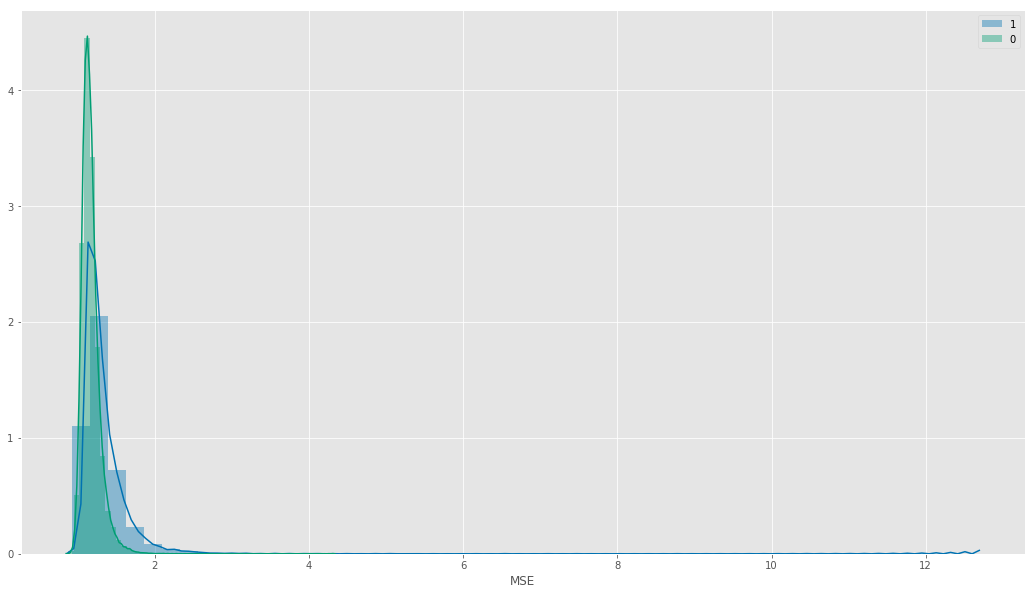

In [ ]:
fig, ax = plt.subplots(figsize = (18, 10))
ax = sns.distplot(results_df[results_df['labels'] == 1]['MSE'], label = '1')
ax = sns.distplot(results_df[results_df['labels'] == 0]['MSE'], label = '0')
ax.legend()

In [ ]:
results_df = results_df.drop('labels', axis = 1)

The Kmeans can't help me to select those data with too high MSE.